## Library import

In [2]:
import os
import pandas as pd 
import numpy as np
import time 
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

## Prepare dataset

In [3]:
userPATH ='revision_dataset/'
tweetPATH ='revision_dataset/'

In [4]:
userlvltrain = pd.read_csv(userPATH+'/userlvltrain.csv')
userlvltest = pd.read_csv(userPATH+'/userlvltest.csv')
userlvlval = pd.read_csv(userPATH+'/userlvlval.csv')

In [5]:
train_df = pd.read_csv(tweetPATH+'/train_df.csv')
test_df = pd.read_csv(tweetPATH+'/test_df.csv')
val_df = pd.read_csv(tweetPATH+'/val_df.csv')

In [6]:
tweets_xtrain_df = pd.DataFrame()
tweets_xtest_df = pd.DataFrame()
tweets_xval_df = pd.DataFrame()

tweets_xtrain_df['text'] = train_df.text.copy()
tweets_xtrain_df['label'] = train_df.Lvalue.copy()
tweets_xval_df['text'] = val_df.text.copy()
tweets_xval_df['label'] = val_df.Lvalue.copy()
tweets_xtest_df['text'] = test_df.text.copy()
tweets_xtest_df['label'] = test_df.Lvalue.copy()

In [7]:
tokenizer = Tokenizer(oov_token=True)
tokenizer.fit_on_texts(tweets_xtrain_df.text)
word_index = tokenizer.word_index

# The maximum number of words to be used. 
vocab_size = len(word_index) + 1 
# Max number of words in each tweets.  
maxlen = tweets_xtrain_df.text.str.len().max() 
# This is fixed.
embedding_size = 400
batch_size = 128

print(vocab_size, "vocab size")
print(maxlen, "max len")
print(embedding_size, "embedding dim")
print(batch_size, "batch size")

94654 vocab size
282 max len
400 embedding dim
128 batch size


In [8]:
Y_train = tweets_xtrain_df.label
Y_test = tweets_xtest_df.label
Y_valid = tweets_xval_df.label

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(userlvltrain.userLocation)
label_names = le.classes_
label_names

array(['bali dan nusa tenggara', 'jabodetabek', 'jawa barat dan banten',
       'jawa tengah dan yogyakarta', 'jawa timur', 'kalimantan',
       'maluku dan papua', 'sulawesi', 'sumatera'], dtype=object)

In [9]:
# tokenizer and padding
X_train = tokenizer.texts_to_sequences(tweets_xtrain_df.text.values)
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = tokenizer.texts_to_sequences(tweets_xtest_df.text.values) 
X_test = pad_sequences(X_test, maxlen=maxlen)
X_valid = tokenizer.texts_to_sequences(tweets_xval_df.text.values) 
X_valid = pad_sequences(X_valid, maxlen=maxlen)

## Word2Vec

In [10]:
if not os.path.exists('Word2Vec_400dim.txt'):
  os.system('gdown https://drive.google.com/uc?id=1L6vzEGcojvEecWt_Ide357THYwMRycGv')

# Ambil word2vec setiap kata
# https://github.com/vijayaiitk/NLP-text-classification-model/issues/1
# https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4
import gensim

modelword2vec = gensim.models.KeyedVectors.load_word2vec_format("Word2Vec_400dim.txt", binary=False)

w2v = dict(zip(modelword2vec.index_to_key, modelword2vec.vectors))


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec['dan'])
        
    def tokenize(self, sentences):
        return [sentence.lower().split(" ") for sentence in sentences]

    
    def transform(self, X):
        # Ambil kata-katanya lalu rata-rata
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
vectorizer = MeanEmbeddingVectorizer(w2v)

In [11]:
embeddings_index = {}
f = open(os.path.join('', 'Word2Vec_400dim.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((vocab_size, embedding_size))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector
print('Embedding matrix', len(embedding_matrix))

Found 129391 word vectors.
Embedding matrix 94654


## LSTM 

In [12]:
def summarize_keras_trainable_variables(model, message):
  s = sum(map(lambda x: x.sum(), model.get_weights()))
  print("summary of trainable variables %s: %.13f" % (message, s))
  return s

### LSTM training and Evaluation

In [13]:
LSTM_X_train = X_train 
LSTM_X_test = X_test 
LSTM_X_valid = X_valid 
LSTM_Y_train = pd.get_dummies(Y_train).values
LSTM_Y_test = pd.get_dummies(Y_test).values
LSTM_Y_valid = pd.get_dummies(Y_valid).values

summary of trainable variables before training: 55063.7746362686157
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 400)         37861600  
                                                                 
 lstm (LSTM)                 (None, 128)               270848    
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 38,203,113
Trainable params: 341,513
Non-trainable params: 37,861,600
____________________________________

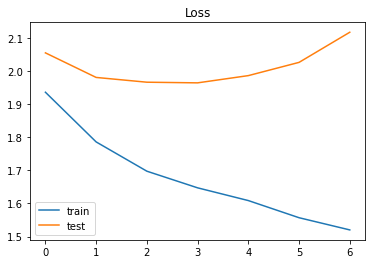

In [14]:
from __future__ import print_function
from numpy.random import seed
import random
import tensorflow as tf

import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"]="3"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


seed(42)
random.seed(12345)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from tensorflow.python.keras import backend as K
tf.random.set_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

lstm_w2v = Sequential()
lstm_w2v.add(Embedding(input_dim= vocab_size, output_dim=embedding_size, weights=[embedding_matrix], trainable=False))
lstm_w2v.add(LSTM(128)) 
lstm_w2v.add(Dense(4*128, activation='relu'))
lstm_w2v.add(Dropout(0.25))
lstm_w2v.add(Dense(9, activation='softmax'))
lstm_w2v.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=5e-3), metrics=['accuracy'])

summarize_keras_trainable_variables(lstm_w2v, "before training")
lstm_w2v.summary()

epochs = 30

history = lstm_w2v.fit(LSTM_X_train, LSTM_Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(LSTM_X_valid, LSTM_Y_valid),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001, restore_best_weights=True
)])

summarize_keras_trainable_variables(lstm_w2v, "after training")

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

newy_pred= lstm_w2v.predict(LSTM_X_test) 
newy_pred_df = pd.DataFrame(newy_pred)
ypred = newy_pred_df.idxmax(axis=1)

pred = test_df[['screen_name']].copy()
pred['Lpredict'] = ypred
y_pred = pred.groupby(['screen_name'], sort=False).agg(lambda x:x.value_counts().index[0])

print('accuracy %s' % round(accuracy_score(userlvltest.Lvalue, y_pred),2 ))
print(classification_report(userlvltest.Lvalue, y_pred,target_names=label_names))

accuracy 0.38
                            precision    recall  f1-score   support

    bali dan nusa tenggara       0.70      0.27      0.39        26
               jabodetabek       0.67      0.07      0.13        28
     jawa barat dan banten       0.62      0.31      0.42        32
jawa tengah dan yogyakarta       0.60      0.33      0.43        36
                jawa timur       0.20      0.91      0.33        34
                kalimantan       0.67      0.18      0.29        22
          maluku dan papua       0.79      0.65      0.71        23
                  sulawesi       0.71      0.25      0.37        20
                  sumatera       0.71      0.34      0.47        29

                  accuracy                           0.38       250
                 macro avg       0.63      0.37      0.39       250
              weighted avg       0.61      0.38      0.39       250



In [16]:
y_pred.to_csv('lstm_result/lstm_majority_vote_word2vec.csv')